In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')
from sklearn import decomposition

from sklearn import preprocessing, decomposition, model_selection, linear_model, metrics, ensemble, svm, utils
from sklearn.datasets import make_classification
from sklearn import preprocessing

In [92]:
# Get the data
train_transaction = pd.read_csv('data/train_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [93]:
# Join datasets
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(f'Shape of train set: {train.shape}')
print(f'Shape of test set: {test.shape}')

Shape of train set: (590540, 435)
Shape of test set: (506691, 434)


In [94]:
# Reduce memory usage
def reduce_mem(df):
  start_mem=df.memory_usage().sum()/1024**2
  print('Initial Memory Usage : {:.2f} MB'.format(start_mem))
  for col in df.columns:
    col_type=df[col].dtype
    if col_type != object:
      mn, mx = df[col].min(), df[col].max()
      if str(col_type)[:3]=='int':
        if mn>np.iinfo(np.int8).min and mx<np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif mn>np.iinfo(np.int16).min and mx<np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif mn>np.iinfo(np.int32).min and mx<np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
      else:
        if mn>np.finfo(np.float16).min and mx<np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif mn>np.finfo(np.float32).min and mx<np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
  end_mem = df.memory_usage().sum()/1024**2
  print('Final Memory Usage : {:.2f} MB'.format(end_mem))
  print('Decreased by {:.2f}%'.format(100*(start_mem-end_mem)/start_mem))
  return df

In [95]:
train = reduce_mem(train)
test = reduce_mem(test)

Initial Memory Usage : 1959.88 MB
Final Memory Usage : 648.22 MB
Decreased by 66.93%
Initial Memory Usage : 1677.73 MB
Final Memory Usage : 563.43 MB
Decreased by 66.42%


In [96]:
import gc
del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

171

Text(0.5, 1.0, 'Target distribution')

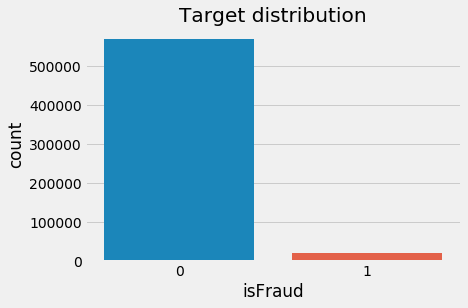

In [97]:
sns.countplot(train['isFraud']) #Imbalanced Dataset
plt.title('Target distribution')

In [98]:
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]

print(len(not_fraud))
print(len(fraud))

# Downsample the data and re-concatenate
not_fraud_downsampled = utils.resample(not_fraud, replace=False, n_samples = len(fraud), random_state = 27) 
train = pd.concat([not_fraud_downsampled, fraud])

569877
20663
        TransactionID_x  isFraud  TransactionDT  TransactionAmt ProductCD  \
578834          3565834        0       15427537       55.000000         W   
257029          3244029        0        6150574       97.000000         W   
6870            2993870        0         231776       84.562500         C   
4985            2991985        0         171531      160.000000         W   
551080          3538080        0       14569477       15.000000         H   
580930          3567930        0       15514357      100.000000         R   
574885          3561885        0       15277964       39.000000         W   
13263           3000263        0         389932      100.000000         R   
509012          3496012        0       13328896       67.937500         W   
580569          3567569        0       15475116       24.500000         W   
451637          3438637        0       11538851      213.000000         W   
53703           3040703        0        1268554      107.937500

In [99]:
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]

print(len(not_fraud))
print(len(fraud))

20663
20663


In [100]:
y = train.isFraud.values

train = train.drop('isFraud', axis=1)
test = test.copy()

# Delete rows with more than 70%? of NaNs, and fill out the rest with some value
train = train.fillna(-1)
test = test.fillna(-1) 

In [101]:

# Label Encoding
for f in train.columns:
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values)) 

In [102]:
scaler = preprocessing.StandardScaler() # MinMaxScaler StandardScaler RobustScaler
cols = list(train.columns)
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])

In [103]:


N = 100

svd = decomposition.TruncatedSVD(n_components=N, random_state=42)
X = svd.fit_transform(train[cols], y)  
svd.explained_variance_ratio_.sum()

0.8896420962024872

In [82]:
df = pd.DataFrame()
df["target"] = y

for i in range(50):
    df[i] = X[:,i]
    
df.tail()

,target,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
41321,1,-7.274425,-2.434995,0.644046,2.809025,0.634984,-1.750463,-0.015028,-1.261183,-1.434944,...,0.330432,0.337356,0.513352,-0.386590,1.484966,-0.948303,0.296222,-0.447871,-1.672870,-0.231984
41322,1,2.320717,10.553606,-0.071589,1.518254,-2.989997,3.222051,0.319521,0.119295,-0.249573,...,-0.382122,0.542973,-0.404028,0.455662,0.467185,-0.359617,0.071821,0.109476,-0.344005,-0.169389
41323,1,11.627554,-9.554371,-4.780394,4.122659,-3.484868,-0.330167,0.288087,0.697586,2.843290,...,-0.039559,-0.093045,0.446380,0.924324,0.183906,-0.277624,0.486994,-1.072419,-0.615087,-0.314333
41324,1,-6.883873,-2.133174,0.550689,2.688653,0.277366,-1.189591,-0.036256,-1.069560,-1.321584,...,-0.040093,0.297347,0.328752,-0.508769,0.594504,-0.741780,0.894374,0.022014,0.676021,0.028770
41325,1,11.483977,-9.625266,-4.793975,4.128294,-3.415947,-0.399210,0.256656,0.663001,2.817799,...,1.789179,0.552577,0.065178,0.612962,0.566421,-0.439535,0.281355,-1.517370,-0.301022,-0.702158


In [90]:
%%time

skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "reg"

#reg = linear_model.LogisticRegression(C=1, solver="newton-cg", penalty="l2", n_jobs=-1, max_iter=200).fit(X_train, y_train) 
reg = ensemble.RandomForestClassifier(n_estimators=200,criterion='gini',n_jobs=-1).fit(X_train, y_train) 
#reg = svm.SVC(max_iter=200).fit(X_train, y_train)
# try gaussianNB()

y_pred = reg.predict_proba(X_valid)
print(y_valid)
print(y_pred)
print(metrics.classification_report(y_valid, [round(y[1]) for y in y_pred]))

[0 0 0 ... 0 0 0]
[[1.    0.   ]
 [0.995 0.005]
 [0.995 0.005]
 ...
 [1.    0.   ]
 [0.96  0.04 ]
 [0.98  0.02 ]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11389
           1       0.80      0.20      0.32       421

    accuracy                           0.97     11810
   macro avg       0.89      0.60      0.65     11810
weighted avg       0.97      0.97      0.96     11810

CPU times: user 2min 38s, sys: 338 ms, total: 2min 38s
Wall time: 13.9 s
